# Notebook 10.7

Julia Zeh, 4/6/18

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

/Users/juliazeh/miniconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Generate data

In [23]:
# fix a random seed
np.random.seed(12345)

# generate extinction data 1600 to 1840 with higher rates after 1760 (Industrial Revolution)
data = pd.DataFrame({
    "year": np.arange(1600, 1840),
    "extinctions": np.concatenate([
        np.random.poisson(5.0, 160), #5 extinctions on average (2 extinctions per year for the first 300 years) - based on the background extinction rate
        np.random.poisson(10.0, 80), #10 extinctions for the last 80 years
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 8) #sample 8 randomly
data.loc[missing, "extinctions"] = np.nan

In [24]:
data.head()

,extinctions,year
0,4.0,1600
1,7.0,1601
2,7.0,1602
3,8.0,1603
4,3.0,1604


In [25]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.extinctions, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N extinctions",
);

1600 1700 1800 year 0 5 10 15 20 N extinctions

### 2. Choose model

In [26]:
with pm.Model() as extinction_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform( #sample points along this continuum of years - uniform distribution, discrete random variables
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1720)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.) #draw two exponential variables - wait time until disasters
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate) #rate is consequence of deterministic variables

    disasters = pm.Poisson('extinctions', rate, observed=data.extinctions)

### 3. Fit, plot, and summarize

In [37]:
with extinction_model:
    trace = pm.sample(10000)

/Users/juliazeh/miniconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [extinctions_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
100%|█████████▉| 10451/10500 [00:10<00:00, 950.96it/s]/Users/juliazeh/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/juliazeh/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 10500/10500 [00:11<00:00, 949.79it/s]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is sm

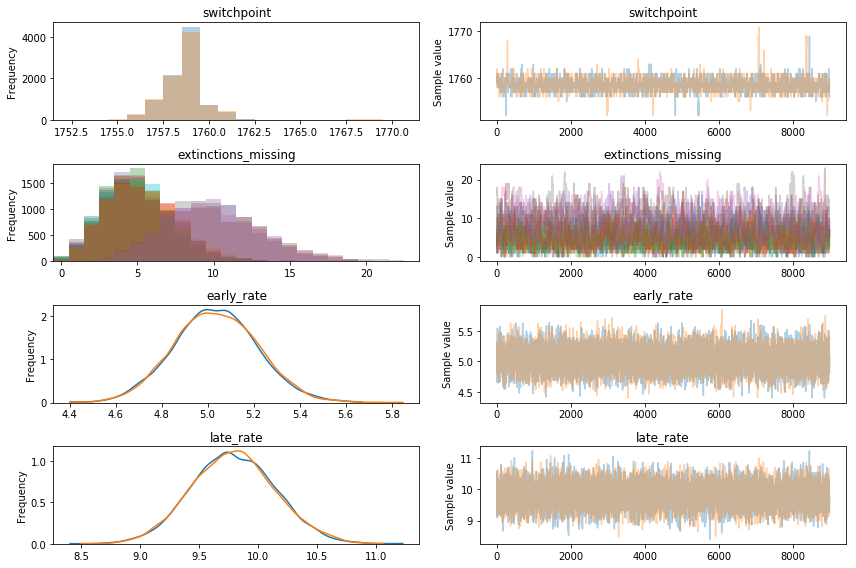

In [38]:
pm.traceplot(trace[1000:]); #slice to throw out the first 1000 variables

In [39]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1758.657050,1.252292,0.027862,1757.000000,1761.000000,1927.0,1.000026
extinctions_missing__0,5.070250,2.260888,0.081451,1.000000,9.000000,547.0,1.000177
extinctions_missing__1,5.146900,2.265286,0.078319,1.000000,9.000000,730.0,0.999984
extinctions_missing__2,4.988950,2.272912,0.079204,1.000000,9.000000,703.0,0.999960
extinctions_missing__3,5.274750,2.354817,0.087406,0.000000,9.000000,581.0,1.001391
extinctions_missing__4,4.786050,2.220332,0.078891,1.000000,9.000000,753.0,1.000026
extinctions_missing__5,5.042000,2.292016,0.085414,1.000000,9.000000,652.0,1.003566
extinctions_missing__6,9.823150,3.128893,0.153276,3.000000,15.000000,348.0,1.000150
extinctions_missing__7,9.912550,3.330256,0.167512,4.000000,16.000000,309.0,1.000022
early_rate,5.034358,0.180860,0.001996,4.684257,5.388183,8852.0,1.000111


### 4. Summary

My model very closely predicted my generative parameters. The posterior mean estimate is very close to 1760. The 95% HPD interval was 1757-1761, which includes my generative parameter of 1760. The early and rate lates were very close to 5 and 10, with a 95% HPD interval of 4.7-5.4 and 9.1-10.4.

I tried running the model for shorter and longer and the shorter MCMC sampler was less accurate. When I ran the MCMC sampler for longer,  the estimated switchpoints and the 95% HPD interval remained about the same, so I think I ran the sampler for long enough. I don't think anything went wrong, but I would have liked to try a more complex model which may have allowed for multiple switchpoints. I tried reading to find out if I could use the same model used here to predict multiple switchpoints, but had trouble finding something, so I kept my model simple. 